<a href="https://colab.research.google.com/github/andrewright17/Homework-1-Deep-Learning/blob/main/simulate_fn_2_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 1-1 Simulate Function
## Function 2

The function we are simulating in this notebook is,

$$
f(x) = \frac{x^3e^{(x/10)}}{15}
$$

## Import Libraries And Check GPU

In [1]:
### import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# set random seed
torch.manual_seed(42)

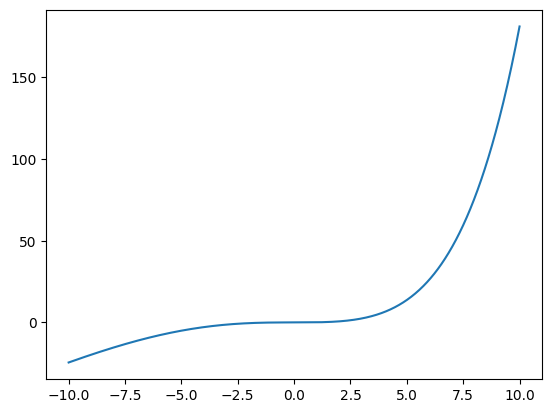

In [26]:
def fn(x):
    return ((x**3)*np.exp(x/10))/15
xvec = np.linspace(-10,10,1000)
yvec = fn(xvec)
plt.plot(xvec,yvec)

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

Device cuda


## Define Function and Generate Training Data

In [4]:
### Define second function
# Define the function to approximate
def fn2(x):
    return ((x**3)*torch.exp(x/10))/15

In [5]:
### Generate training data
x_train = torch.linspace(-10, 10, 2000).unsqueeze(1)
y_train = fn2(x_train)

# validation data
x_test = torch.linspace(-10, 10, 100).unsqueeze(1)
x_test = x_test.to(device)
y_test = fn2(x_test)

## Model Class

In [6]:
class model_class(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=None):
        super(model_class, self).__init__()

        # Store model architecture parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes or []

        # Create layers
        layers = []
        in_features = input_size
        for h_size in hidden_sizes:
            layers.append(nn.Linear(in_features, h_size))
            layers.append(nn.ReLU())  # Add activation after each hidden layer
            in_features = h_size
        layers.append(nn.Linear(in_features, output_size))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        # Forward pass through the layers
        for layer in self.layers:
            x = layer(x)
        return x


## Training Function

In [7]:
def train_model(model, X_train, Y_train, batch, epochs, learning_rate):
  # send data to device
  X_train, Y_train = X_train.to(device), Y_train.to(device)

  # load training data for model 1
  data_loader = DataLoader(TensorDataset(X_train,Y_train), batch_size=batch, shuffle = True)

  # Create optimizer and loss function
  optimizer = optim.Adam(model.parameters(), lr = learning_rate)
  loss_fn = nn.MSELoss()

  # Send model to device
  model.to(device)

  # Training loop for model 1
  loss_vec = []
  for epoch in range(epochs):
      epoch_loss = 0.0
      for i,data in enumerate(data_loader):
          x_batch, y_batch = data
          optimizer.zero_grad()
      #print(x_train.shape)
          y_pred = model(x_batch)
          loss = loss_fn(y_pred, y_batch)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
      loss_vec.append(epoch_loss)
  return loss_vec


## Hyperparameter Tuning and Training

In [8]:
# Define hyperparameter grid
hyperparameter_grid = {
    'batch_size': [8, 16, 32, 64],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1]
}

In [9]:
# Initialize best model and best validation score
best_model = None
best_mse = float('inf')

# Iterate through hyperparameter combinations using itertools.product
for batch_size, learning_rate in itertools.product(*hyperparameter_grid.values()):
    # Create model instance
    model1 = model_class(input_size = 1, output_size = 1, hidden_sizes = [75,25])

    # Train the model
    model1_loss = train_model(model1, x_train, y_train, batch = batch_size, epochs = 100, learning_rate = learning_rate)

    # Evaluate the model on validation set
    mse = nn.functional.mse_loss(model1(x_test), y_test)  # Replace with your evaluation function
    print(f"MSE: {mse}, batch_size: {batch_size}, lr: {learning_rate}")
    # Update best model and score if necessary
    if mse < best_mse:
        best_model_loss = model1_loss
        best_model = model1
        best_mse = mse
        best_batch_size = batch_size
        best_learning_rate = learning_rate

# Print best hyperparameters and score
print(f"Best validation score: {best_mse:.4f}")
print(f"Best batch size: {best_batch_size}")
print(f"Best learning rate: {best_learning_rate}")

MSE: 17.667531967163086, batch_size: 8, lr: 0.0001
MSE: 0.2813880443572998, batch_size: 8, lr: 0.001
MSE: 2.9992330074310303, batch_size: 8, lr: 0.01
MSE: 3.470799446105957, batch_size: 8, lr: 0.1
MSE: 103.05406951904297, batch_size: 16, lr: 0.0001
MSE: 0.10814590007066727, batch_size: 16, lr: 0.001
MSE: 0.5055844187736511, batch_size: 16, lr: 0.01
MSE: 2.1226985454559326, batch_size: 16, lr: 0.1
MSE: 203.36622619628906, batch_size: 32, lr: 0.0001
MSE: 1.1897398233413696, batch_size: 32, lr: 0.001
MSE: 3.3163137435913086, batch_size: 32, lr: 0.01
MSE: 0.49750930070877075, batch_size: 32, lr: 0.1
MSE: 368.2030334472656, batch_size: 64, lr: 0.0001
MSE: 3.766376256942749, batch_size: 64, lr: 0.001
MSE: 1.1778364181518555, batch_size: 64, lr: 0.01
MSE: 0.2250833809375763, batch_size: 64, lr: 0.1
Best validation score: 0.1081
Best batch size: 16
Best learning rate: 0.001


In [10]:
# assign model 1
model1 = best_model
model1_loss = best_model_loss

In [11]:
# Initialize best model and best validation score
best_model = None
best_mse = float('inf')

# Iterate through hyperparameter combinations using itertools.product
for batch_size, learning_rate in itertools.product(*hyperparameter_grid.values()):
    # Create model instance
    model2 = model_class(input_size = 1, output_size = 1, hidden_sizes = [17, 26, 25, 23, 12])

    # Train the model
    model2_loss = train_model(model2, x_train, y_train, batch = batch_size, epochs = 100, learning_rate = learning_rate)

    # Evaluate the model on validation set
    mse = nn.functional.mse_loss(model2(x_test), y_test)  # Replace with your evaluation function
    print(f"MSE: {mse}, batch_size: {batch_size}, lr: {learning_rate}")
    # Update best model and score if necessary
    if mse < best_mse:
        best_model_loss = model2_loss
        best_model = model2
        best_mse = mse
        best_batch_size = batch_size
        best_learning_rate = learning_rate

# Print best hyperparameters and score
print(f"Best validation score: {best_mse:.4f}")
print(f"Best batch size: {best_batch_size}")
print(f"Best learning rate: {best_learning_rate}")

MSE: 0.8158681392669678, batch_size: 8, lr: 0.0001
MSE: 0.055464282631874084, batch_size: 8, lr: 0.001
MSE: 0.6799328327178955, batch_size: 8, lr: 0.01
MSE: 1832.938720703125, batch_size: 8, lr: 0.1
MSE: 6.40192985534668, batch_size: 16, lr: 0.0001
MSE: 3.1212146282196045, batch_size: 16, lr: 0.001
MSE: 0.07010643929243088, batch_size: 16, lr: 0.01
MSE: 451.0450744628906, batch_size: 16, lr: 0.1
MSE: 14.742390632629395, batch_size: 32, lr: 0.0001
MSE: 0.596867561340332, batch_size: 32, lr: 0.001
MSE: 0.06121295318007469, batch_size: 32, lr: 0.01
MSE: 26.265390396118164, batch_size: 32, lr: 0.1
MSE: 110.20932006835938, batch_size: 64, lr: 0.0001
MSE: 1.69268798828125, batch_size: 64, lr: 0.001
MSE: 0.06135324016213417, batch_size: 64, lr: 0.01
MSE: 1.3565446138381958, batch_size: 64, lr: 0.1
Best validation score: 0.0555
Best batch size: 8
Best learning rate: 0.001


In [12]:
# assign model 2
model2 = best_model
model2_loss = best_model_loss

In [13]:
# Initialize best model and best validation score
best_model = None
best_mse = float('inf')

# Iterate through hyperparameter combinations using itertools.product
for batch_size, learning_rate in itertools.product(*hyperparameter_grid.values()):
    # Create model instance
    model3 = model_class(1, 1, [692])

    # Train the model
    model3_loss = train_model(model3, x_train, y_train, batch = batch_size, epochs = 100, learning_rate = learning_rate)

    # Evaluate the model on validation set
    mse = nn.functional.mse_loss(model3(x_test), y_test)  # Replace with your evaluation function
    print(f"MSE: {mse}, batch_size: {batch_size}, lr: {learning_rate}")
    # Update best model and score if necessary
    if mse < best_mse:
        best_model_loss = model3_loss
        best_model = model3
        best_mse = mse
        best_batch_size = batch_size
        best_learning_rate = learning_rate

# Print best hyperparameters and score
print(f"Best validation score: {best_mse:.4f}")
print(f"Best batch size: {best_batch_size}")
print(f"Best learning rate: {best_learning_rate}")

MSE: 60.76613998413086, batch_size: 8, lr: 0.0001
MSE: 0.07331142574548721, batch_size: 8, lr: 0.001
MSE: 0.1624215543270111, batch_size: 8, lr: 0.01
MSE: 7.339722156524658, batch_size: 8, lr: 0.1
MSE: 136.14877319335938, batch_size: 16, lr: 0.0001
MSE: 0.362467885017395, batch_size: 16, lr: 0.001
MSE: 0.7158713936805725, batch_size: 16, lr: 0.01
MSE: 1.2346895933151245, batch_size: 16, lr: 0.1
MSE: 230.29019165039062, batch_size: 32, lr: 0.0001
MSE: 2.4058258533477783, batch_size: 32, lr: 0.001
MSE: 1.450743317604065, batch_size: 32, lr: 0.01
MSE: 0.17631670832633972, batch_size: 32, lr: 0.1
MSE: 330.4446716308594, batch_size: 64, lr: 0.0001
MSE: 12.403975486755371, batch_size: 64, lr: 0.001
MSE: 0.20562294125556946, batch_size: 64, lr: 0.01
MSE: 1.866699457168579, batch_size: 64, lr: 0.1
Best validation score: 0.0733
Best batch size: 8
Best learning rate: 0.001


In [14]:
# assign model 3
model3 = best_model
model3_loss = best_model_loss

## Model Evaluation and Plotting

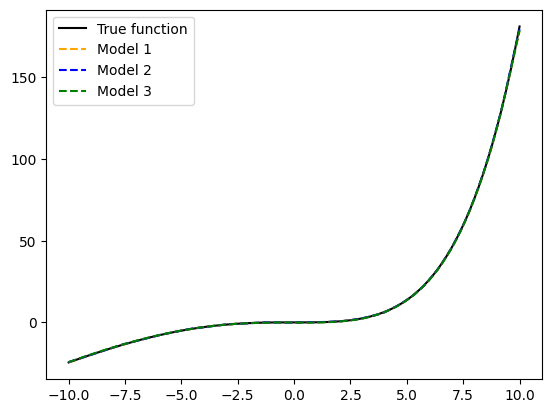

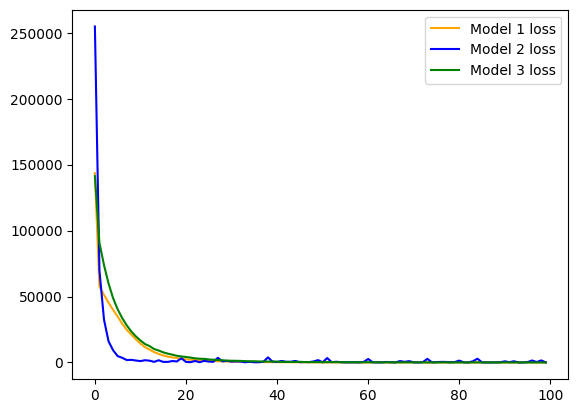

In [25]:
# Evaluate the model
x_test = torch.linspace(-10, 10, 100).unsqueeze(1)
x_test = x_test.to(device)
y_test = fn2(x_test)
y_pred1 = model1(x_test)
y_pred2 = model2(x_test)
y_pred3 = model3(x_test)
### Visualize plots
plt.plot(x_test.cpu().detach(), y_test.cpu().detach(), label="True function", color = 'black')
plt.plot(x_test.cpu().detach(), y_pred1.cpu().detach(), label="Model 1", color = 'orange', linestyle = 'dashed')
plt.plot(x_test.cpu().detach(), y_pred2.cpu().detach(), label="Model 2", color = 'blue', linestyle = 'dashed')
plt.plot(x_test.cpu().detach(), y_pred3.cpu().detach(), label="Model 3", color = 'green', linestyle = 'dashed')
plt.legend()
plt.show()
plt.plot(np.arange(0,len(model1_loss),1),np.array(model1_loss), label="Model 1 loss", color = 'orange')
plt.plot(np.arange(0,len(model1_loss),1),np.array(model2_loss), label="Model 2 loss", color = 'blue')
plt.plot(np.arange(0,len(model1_loss),1),np.array(model3_loss), label="Model 3 loss", color = 'green')
#plt.ylim(0, 500)
plt.legend()
plt.show()

In [16]:
# print MSE for models on test set
print(f"Model 1 MSE: {nn.functional.mse_loss(y_pred1, y_test)}")
print(f"Model 2 MSE: {nn.functional.mse_loss(y_pred2, y_test)}")
print(f"Model 3 MSE: {nn.functional.mse_loss(y_pred3, y_test)}")

Model 1 MSE: 0.10814590007066727
Model 2 MSE: 0.055464282631874084
Model 3 MSE: 0.07331142574548721


## Check Parameter Sizes

In [17]:
### Check model parameters
model1_parameters = filter(lambda p: p.requires_grad, model1.parameters())
params1 = sum([np.prod(p.size()) for p in model1_parameters])
print(f'Model 1 parameters: {params1}') #2076

model2_parameters = filter(lambda p: p.requires_grad, model2.parameters())
params2 = sum([np.prod(p.size()) for p in model2_parameters])
print(f'Model 1 parameters: {params1}') #2076

model3_parameters = filter(lambda p: p.requires_grad, model3.parameters())
params3 = sum([np.prod(p.size()) for p in model3_parameters])
print(f'Model 3 parameters: {params3}') #2077

Model 1 parameters: 2076
Model 1 parameters: 2076
Model 3 parameters: 2077
